In [ ]:
# Install required packages
!pip install transformers
!pip install torch
!pip install emoji

# Mount Google Drive if necessary
from google.colab import drive
drive.mount('/content/drive')


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.5/421.5 kB 2.9 MB/s eta 0:00:00
Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, AdamW
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import re
import string
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

class BERTCNN(nn.Module):
    def __init__(self, num_classes):
        super(BERTCNN, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.conv1 = nn.Conv1d(768, 128, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(128, 64, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(kernel_size=3, padding=1)  # Adjust kernel size and padding
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(64 * 12, 64)  # Adjust input size to match the output size of the max pooling layer
        self.fc2 = nn.Linear(64, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state.permute(0, 2, 1)  # [batch_size, hidden_size, seq_len]
        conv1_out = self.conv1(last_hidden_state)
        conv1_out = self.relu(conv1_out)
        conv2_out = self.conv2(conv1_out)
        conv2_out = self.relu(conv2_out)
        pooled_out = self.maxpool(conv2_out)
        flattened = pooled_out.view(pooled_out.size(0), -1)
        fc1_out = self.fc1(flattened)
        fc1_out = self.relu(fc1_out)
        fc1_out = self.dropout(fc1_out)
        fc2_out = self.fc2(fc1_out)
        output = self.sigmoid(fc2_out)
        return output

# Preprocess dataset
def pre_process_dataset(values):
    new_values = []
    emoticons = [':-)', ':)', '(:', '(-:', ':))', '((:', ':-D', ':D', 'X-D', 'XD', 'xD', 'xD', '<3', '</3', ':\*',
                 ';-)',
                 ';)', ';-D', ';D', '(;', '(-;', ':-(', ':(', '(:', '(-:', ':,(', ':\'(', ':"(', ':((', ':D', '=D',
                 '=)',
                 '(=', '=(', ')=', '=-O', 'O-=', ':o', 'o:', 'O:', 'O:', ':-o', 'o-:', ':P', ':p', ':S', ':s', ':@',
                 ':>',
                 ':<', '^_^', '^.^', '>.>', 'T_T', 'T-T', '-.-', '*.*', '~.~', ':*', ':-*', 'xP', 'XP', 'XP', 'Xp',
                 ':-|',
                 ':->', ':-<', '$_$', '8-)', ':-P', ':-p', '=P', '=p', ':*)', '*-*', 'B-)', 'O.o', 'X-(', ')-X']
    for value in values:
        text = value.replace(".", " ").lower()
        text = re.sub(r"[^a-zA-Z?.!,¿]+", " ", text)
        users = re.findall("[@]\w+", text)
        for user in users:
            text = text.replace(user, "<user>")
        urls = re.findall(r'(https?://[^\s]+)', text)
        if len(urls) != 0:
            for url in urls:
                text = text.replace(url, "<url>")
        for emo in emoticons:
            text = text.replace(emo, "<emoticon>")
        numbers = re.findall('[0-9]+', text)
        for number in numbers:
            text = text.replace(number, "<number>")
        text = text.replace('#', "<hashtag>")
        text = re.sub(r"([?.!,¿])", r" ", text)
        text = "".join(l for l in text if l not in string.punctuation)
        text = re.sub(r'[" "]+', " ", text)
        new_values.append(text)
    return new_values

# Process data
def data_process(data, labels):
    input_ids = []
    attention_masks = []
    bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    for sentence in data:
        bert_inp = bert_tokenizer.__call__(sentence, max_length=36,
                                           padding='max_length', pad_to_max_length=True,
                                           truncation=True, return_token_type_ids=False)
        input_ids.append(bert_inp['input_ids'])
        attention_masks.append(bert_inp['attention_mask'])
    input_ids = np.asarray(input_ids)
    attention_masks = np.array(attention_masks)
    labels = np.array(labels)
    return input_ids, attention_masks, labels

# Load and preprocess data
def load_and_process():
    # Adjust file path if dataset is stored in Google Drive
    data = pd.read_csv("/content/drive/MyDrive/HatespeechDataset.csv")
    num_of_labels = len(data['class'].unique())
    input_ids, attention_masks, labels = data_process(pre_process_dataset(data['tweet']), data['class'])
    return input_ids, attention_masks, labels

# Training function for binary classification with added features
# Training function for binary classification with added features
def train(model, train_dataloader, optimizer, criterion):
    model.train()
    total_loss, total_accuracy = 0, 0

    # Empty list to save model predictions
    total_preds = []

    # Iterate over batches
    total_batches = len(train_dataloader)
    for batch_idx, batch in enumerate(train_dataloader, 1):
        # Print progress bar
        progress = batch_idx / total_batches
        print(f"\r[{int(progress * 100):3}%] [{'█' * int(progress * 50):50}] ", end="")

        # Push the batch to GPU
        batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch

        # Clear previously calculated gradients
        optimizer.zero_grad()

        # Get model predictions for the current batch
        preds = model(sent_id, mask)

        # Compute the loss between actual and predicted values
        batch_size = labels.size(0)  # Get the batch size dynamically
        labels = labels.view(batch_size, 1)  # Reshape to [batch_size, 1]
        preds = preds.reshape(batch_size, 1)
        preds = preds.view(batch_size, 1)
        loss = criterion(preds, labels.float())

        # Add to the total loss
        total_loss += float(loss.item())

        # Backward pass to calculate the gradients
        loss.backward()

        # Clip the gradients to prevent the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters
        optimizer.step()

        # Model predictions are stored on GPU. So, push it to CPU and append
        total_preds.extend(preds[:batch_size].detach().cpu().numpy())  # Trim predictions to match label batch size

    # Compute the training loss of the epoch
    avg_loss = total_loss / total_batches

    # Reshape the predictions
    total_preds = np.array(total_preds)

    # Returns the loss and predictions
    return avg_loss, total_preds


# Function for evaluating the model
def evaluate(model, val_dataloader, criterion):
    print("\n\nEvaluating...")

    # Deactivate dropout layers
    model.eval()

    total_loss, total_accuracy = 0, 0

    # Empty list to save the model predictions
    total_preds = []

    # Iterate over batches
    total = len(val_dataloader)
    batch_size = 128  # Match the batch size used during training
    for i, batch in enumerate(val_dataloader):

        step = i + 1
        percent = "{0:.2f}".format(100 * (step / float(total)))
        filledLength = int(50 * step // total)
        bar = '█' * filledLength + '-' * (50 - filledLength)
        print(f'\rEvaluating |{bar}| {percent}% complete', end='')

        # Push the batch to GPU
        batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch

        # Deactivate autograd
        with torch.no_grad():

            # Model predictions
            preds = model(sent_id, mask)
            # Compute the validation loss between actual and predicted values
            batch_size = labels.size(0)
            labels = labels.view(batch_size, 1)  # Reshape to [batch_size, 1]
            preds = preds.reshape(batch_size, 1)
            preds = preds.view(batch_size, 1)
            loss = criterion(preds, labels.float())
            total_loss += float(loss.item())

            # Ensure both predictions and labels have the same batch size
            total_preds.extend(preds[:batch_size].detach().cpu().numpy())  # Trim predictions to match label batch size

    # Compute the validation loss of the epoch
    avg_loss = total_loss / (len(val_dataloader) * batch_size)

    # Print completion message
    print(f'\rEvaluating |{"█" * 50}| 100% complete')

    return avg_loss, total_preds



# Load data
input_ids, attention_masks, labels = load_and_process()

# Check the total number of samples in the dataset
print("Total samples in the dataset:", len(labels))

# Split data into train, validation, and test sets
train_inputs, temp_inputs, train_labels, temp_labels = train_test_split(input_ids, labels,
                                                                         random_state=2018,
                                                                         test_size=0.2,
                                                                         stratify=labels)

val_inputs, test_inputs, val_labels, test_labels = train_test_split(temp_inputs, temp_labels,
                                                                     random_state=2018,
                                                                     test_size=0.5,
                                                                     stratify=temp_labels)

# Check the number of samples in each set after splitting
print("Train set samples:", len(train_labels))
print("Validation set samples:", len(val_labels))
print("Test set samples:", len(test_labels))

# Create DataLoaders
batch_size = 128

# For training dataloader
train_data = TensorDataset(torch.tensor(train_inputs),
                           torch.tensor(attention_masks[:len(train_inputs)]),
                           torch.tensor(train_labels))
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size, drop_last=True)  # Added drop_last=True

# For validation dataloader
val_data = TensorDataset(torch.tensor(val_inputs),
                         torch.tensor(attention_masks[len(train_inputs):len(train_inputs) + len(val_inputs)]),
                         torch.tensor(val_labels))
val_sampler = RandomSampler(val_data)  # Changed from SequentialSampler to RandomSampler
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size, drop_last=True)  # Added drop_last=True



# Ensure all tensors are on the same device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate the BERT-CNN model
model = BERTCNN(num_classes=1)
# Move model to the same device
model.to(device)



# Set up optimizer and loss function
optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = nn.BCEWithLogitsLoss(reduction='mean')

# Train the model
epochs = 10
best_valid_loss = float('inf')

for epoch in range(1, epochs + 1):
    print(f'\nEpoch {epoch}/{epochs}:')
    train_loss, _ = train(model, train_dataloader, optimizer, criterion)
    val_loss, _ = evaluate(model, val_dataloader, criterion)
    if val_loss < best_valid_loss:
        best_valid_loss = val_loss
    print(f'Training Loss: {train_loss:.3f}, Validation Loss: {val_loss:.3f}')

# Create a new test dataloader using the PadSequence object
test_data = TensorDataset(torch.tensor(test_inputs),
                          torch.tensor(attention_masks[len(train_inputs) + len(val_inputs):]),
                          torch.tensor(test_labels))
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)  # Use the same batch size as training
# Evaluate the model on test data
model.eval()
with torch.no_grad():
    preds = []
    for batch in test_dataloader:
        batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch
        pred = model(sent_id, mask)
        preds.extend(pred[:labels.shape[0]].detach().cpu().numpy())  # Trim predictions to match label batch size

# Convert predictions to numpy array and apply threshold
preds = np.array(preds)
preds = np.where(preds >= 0.5, 1, 0)

# Print performance metrics
from sklearn.metrics import classification_report, accuracy_score
print("\nPerformance:")
print('Classification Report')
print(classification_report(test_labels, preds))
print("Accuracy:", accuracy_score(test_labels, preds))
from sklearn.metrics import confusion_matrix

# Print confusion matrix
conf_matrix = confusion_matrix(test_labels, preds)
print("\nConfusion Matrix:")
print(conf_matrix)



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Total samples in the dataset: 24962
Train set samples: 19969
Validation set samples: 2496
Test set samples: 2497


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



Epoch 1/10:
[100%] [██████████████████████████████████████████████████] 

Evaluating...
Evaluating |██████████████████████████████████████████████████| 100% complete
Training Loss: 0.645, Validation Loss: 0.004

Epoch 2/10:
[100%] [██████████████████████████████████████████████████] 

Evaluating...
Evaluating |██████████████████████████████████████████████████| 100% complete
Training Loss: 0.555, Validation Loss: 0.004

Epoch 3/10:
[100%] [██████████████████████████████████████████████████] 

Evaluating...
Evaluating |██████████████████████████████████████████████████| 100% complete
Training Loss: 0.549, Validation Loss: 0.004

Epoch 4/10:
[100%] [██████████████████████████████████████████████████] 

Evaluating...
Evaluating |██████████████████████████████████████████████████| 100% complete
Training Loss: 0.545, Validation Loss: 0.004

Epoch 5/10:
[100%] [██████████████████████████████████████████████████] 

Evaluating...
Evaluating |██████████████████████████████████████████████████|

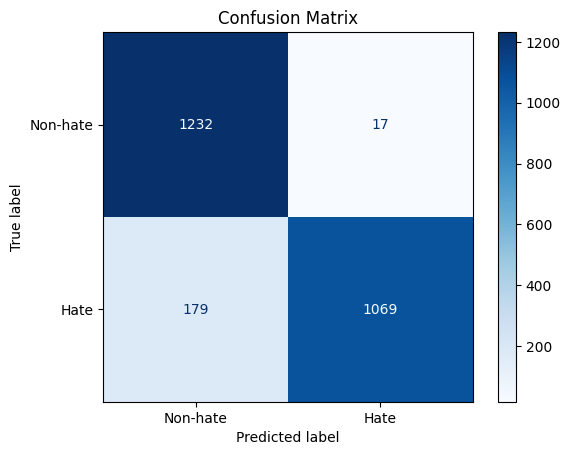

In [ ]:
# Plot Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Non-hate', 'Hate'])
disp.plot(cmap=plt.cm.Blues, values_format='.5g')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
!pip install scipy

In [ ]:
# Save the model
torch.save(model.state_dict(), 'bert_cnn_model.pth')


In [ ]:
# Instantiate the model
model = BERTCNN(num_classes=1)

# Load the saved model state_dict
model.load_state_dict(torch.load('bert_cnn_model.pth'))

# Set the model to evaluation mode
model.eval()


BERTCNN(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [ ]:
def preprocess_and_tokenize(tweet):
    # Preprocess the tweet
    processed_tweet = pre_process_dataset([tweet])[0]

    # Tokenize the processed tweet
    bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    inputs = bert_tokenizer.__call__(processed_tweet, max_length=36,
                                     padding='max_length', pad_to_max_length=True,
                                     truncation=True, return_token_type_ids=False)

    return inputs

def predict(model, tweet_inputs):
    # Convert inputs to tensor
    input_ids = torch.tensor(tweet_inputs['input_ids']).unsqueeze(0)  # Add batch dimension
    attention_mask = torch.tensor(tweet_inputs['attention_mask']).unsqueeze(0)  # Add batch dimension

    # Perform prediction
    with torch.no_grad():
        model_output = model(input_ids, attention_mask)

    # Apply threshold and return prediction
    prediction = 1 if model_output >= 0.5 else 0
    return prediction

# Example tweet
new_tweet = "Queers are an abomination and need to be helped to go straight to Hell!"

# Process and tokenize the tweet
tweet_inputs = preprocess_and_tokenize(new_tweet)

# Predict with the model
prediction = predict(model, tweet_inputs)
print("Predicted Class:", prediction)


Predicted Class: 1
